In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Вспомогательные функции

In [178]:
# Очистка датасета из предыдущего отчета
def clean_dataset(dataset):
    for i in range(dataset.columns.size):
        if (dataset[dataset.columns[i]].isnull().sum() and float(dataset[dataset.columns[i]].isnull().sum()) < dataset.shape[0]/90):
            dataset.dropna(subset=[dataset.columns[i]], inplace=True)

    dataset['Высота потолков, м'].fillna(2.65, inplace=True)
    dataset['Тип этажа'].fillna(
        dataset['Тип этажа'].mode().iloc[0], inplace=True)
    dataset['Состояние ремонта'].fillna('Нет', inplace=True)
    dataset.loc[dataset['Количество комнат']
                == 'Студия', 'Количество комнат'] = 0
    dataset['Дата снятия (продажи)'].fillna(np.nan, inplace=True)
    dataset['Школа\nм'].fillna(
        dataset['Школа\nм'].median(axis=0), inplace=True)
    dataset['Детский сад\nм'].fillna(
        dataset['Детский сад\nм'].median(axis=0), inplace=True)

    return dataset

# категориальный параметр из числового (легче просто использовать команду напрямую)
def number_to_categorical(data, name, div, lbl):
    data[name] = pd.cut(x=data[name], bins=div, labels=lbl, include_lowest=True, right=False)

# логарифмическая гистограмма
def hist(dataset):
    dataset['Удельная цена, руб./кв.м'].hist(bins=20)
    plt.show()
    dataset['Удельная цена, руб./кв.м'].apply(np.log).hist(bins=20)
    plt.show()

### Ранее очищенная таблица

In [179]:
df = pd.read_excel('данные_квартиры.xlsx',
                   usecols=lambda x: 'Unnamed' not in x, skiprows=1)
dataset = clean_dataset(df)

### Переменные с более чем 2 значениями привожу к типу ```category```

In [180]:
for i in dataset.select_dtypes(include=[object]):
    if (dataset[i].unique().size > 2):
        dataset[i]=dataset[i].astype('category')
dataset['Количество комнат'] = dataset['Количество комнат'].astype('int64')
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2572 entries, 0 to 2599
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Тип рынка                              2572 non-null   object  
 1   Функциональная зона                    2572 non-null   category
 2   Общая площадь,
кв.м                    2572 non-null   float64 
 3   Жилая площадь,
кв.м                    2572 non-null   float64 
 4   Площадь кухни,
кв.м                    2572 non-null   float64 
 5   Высота потолков, м                     2572 non-null   float64 
 6   Год постройки                          2572 non-null   int64   
 7   Тип дома                               2572 non-null   category
 8   Класс                                  2572 non-null   category
 9   Этаж                                   2572 non-null   int64   
 10  Этажность                              2572 non-null   float

### Попытка преобразовать общую площадь в нежилую путем вычитания параметров, чтобы избежать мультиколлинеарности

In [181]:
# dataset['Общая площадь,\nкв.м'] = dataset.apply(
#     lambda x: x['Общая площадь,\nкв.м'] - x['Жилая площадь,\nкв.м'] - x['Площадь кухни,\nкв.м'], axis=1)
# dataset = dataset.rename(
#     columns={'Общая площадь,\nкв.м': 'Нежилая площадь,\nкв.м'})

### Матрицы для экспериментов с параметрами

In [182]:
corr_mat = dataset.corr()
corr_mat


,"Общая площадь,\nкв.м","Жилая площадь,\nкв.м","Площадь кухни,\nкв.м","Высота потолков, м",Год постройки,Этаж,Этажность,Количество комнат,"Цена предложения,\nруб.","Удельная цена, руб./кв.м",Колич. Просмотр.,Колич. Просм. в день,Остановка\nм,Парк\nм,Центр\nкм,Станция метро\nм,Школа\nм,Детский сад\nм
"Общая площадь,\nкв.м",1.000000,0.852318,0.566634,0.010368,0.234242,0.109169,0.159461,0.716544,0.755718,0.049822,0.005581,-0.041834,0.061928,-0.045860,-0.219381,-0.002728,-0.003953,-0.026917
"Жилая площадь,\nкв.м",0.852318,1.000000,0.372613,0.096266,0.042208,-0.018208,-0.017750,0.853197,0.706038,-0.046025,0.004996,-0.031467,-0.040372,-0.102710,-0.190421,-0.071878,-0.061369,-0.058139
"Площадь кухни,\nкв.м",0.566634,0.372613,1.000000,-0.249686,0.575652,0.361324,0.474704,0.290810,0.666336,0.335275,0.023859,-0.059969,0.326418,0.132816,-0.191371,0.215328,0.118076,0.055837
"Высота потолков, м",0.010368,0.096266,-0.249686,1.000000,-0.327417,-0.244340,-0.211721,0.022068,-0.038284,-0.154288,-0.016824,0.044824,-0.552758,-0.219645,-0.004399,-0.311017,-0.136898,-0.131174
Год постройки,0.234242,0.042208,0.575652,-0.327417,1.000000,0.540520,0.793301,-0.002435,0.381539,0.409431,0.023899,-0.039421,0.461331,0.298597,-0.083202,0.381569,0.269170,0.148734
Этаж,0.109169,-0.018208,0.361324,-0.244340,0.540520,1.000000,0.631096,-0.025850,0.205277,0.286866,0.024782,-0.027121,0.271777,0.187624,0.010182,0.198496,0.151953,0.042332
Этажность,0.159461,-0.017750,0.474704,-0.211721,0.793301,0.631096,1.000000,-0.014890,0.300779,0.414745,0.009747,-0.040747,0.316926,0.253559,-0.040367,0.225346,0.211923,0.085050
Количество комнат,0.716544,0.853197,0.290810,0.022068,-0.002435,-0.025850,-0.014890,1.000000,0.543656,-0.112381,0.029851,-0.039962,0.011096,-0.051657,-0.142525,-0.025733,-0.050738,-0.058448
"Цена предложения,\nруб.",0.755718,0.706038,0.666336,-0.038284,0.381539,0.205277,0.300779,0.543656,1.000000,0.567446,0.024461,-0.067201,0.118155,-0.052385,-0.334450,0.016011,0.008288,0.001494
"Удельная цена, руб./кв.м",0.049822,-0.046025,0.335275,-0.154288,0.409431,0.286866,0.414745,-0.112381,0.567446,1.000000,0.031852,-0.062982,0.152734,-0.009754,-0.322813,0.046371,0.034604,0.044720


In [183]:
corr_mat.where(np.triu(np.abs(corr_mat) > 0.33, k=1)).stack().sort_values(ascending=False)

Жилая площадь,\nкв.м     Количество комнат           0.853197
Общая площадь,\nкв.м     Жилая площадь,\nкв.м        0.852318
Год постройки            Этажность                   0.793301
Общая площадь,\nкв.м     Цена предложения,\nруб.     0.755718
                         Количество комнат           0.716544
Жилая площадь,\nкв.м     Цена предложения,\nруб.     0.706038
Площадь кухни,\nкв.м     Цена предложения,\nруб.     0.666336
Этаж                     Этажность                   0.631096
Площадь кухни,\nкв.м     Год постройки               0.575652
Цена предложения,\nруб.  Удельная цена, руб./кв.м    0.567446
Общая площадь,\nкв.м     Площадь кухни,\nкв.м        0.566634
Количество комнат        Цена предложения,\nруб.     0.543656
Год постройки            Этаж                        0.540520
Парк\nм                  Станция метро\nм            0.490707
Площадь кухни,\nкв.м     Этажность                   0.474704
Год постройки            Остановка\nм                0.461331
Этажност

In [184]:
corr_mat['Удельная цена, руб./кв.м'].where(corr_mat['Удельная цена, руб./кв.м']>0.2)

Общая площадь,\nкв.м             NaN
Жилая площадь,\nкв.м             NaN
Площадь кухни,\nкв.м        0.335275
Высота потолков, м               NaN
Год постройки               0.409431
Этаж                        0.286866
Этажность                   0.414745
Количество комнат                NaN
Цена предложения,\nруб.     0.567446
Удельная цена, руб./кв.м    1.000000
Колич.  Просмотр.                NaN
Колич.  Просм. в день            NaN
Остановка\nм                     NaN
Парк\nм                          NaN
Центр\nкм                        NaN
Станция метро\nм                 NaN
Школа\nм                         NaN
Детский сад\nм                   NaN
Name: Удельная цена, руб./кв.м, dtype: float64

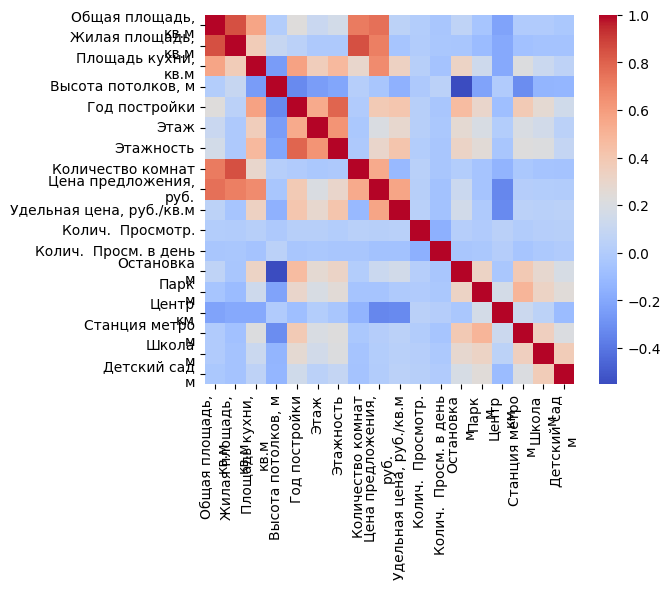

In [185]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm');

### Разделение признаков на бинарные, числовые и категориальные (для удобства обработки)

In [186]:
binary_columns = [i for i in dataset.columns if dataset[i].dtype.name == 'object']
categorical_columns = [i for i in dataset.columns if dataset[i].dtype.name == 'category']
numerical_columns = [i for i in dataset.columns if (dataset[i].dtype.name != 'category' and dataset[i].dtype.name != 'object')]
print(binary_columns)
print(categorical_columns)
print(numerical_columns)

['Тип рынка', 'Парковка', 'Актуальность на дату послед. проверки']
['Функциональная зона', 'Тип дома', 'Класс', 'Тип этажа', 'Состояние ремонта', 'Материал стен', 'Дата создания', 'Дата парсинга', 'Дата послед. проверки', 'Дата снятия (продажи)']
['Общая площадь,\nкв.м', 'Жилая площадь,\nкв.м', 'Площадь кухни,\nкв.м', 'Высота потолков, м', 'Год постройки', 'Этаж', 'Этажность', 'Количество комнат', 'Цена предложения,\nруб.', 'Удельная цена, руб./кв.м', 'Колич.  Просмотр.', 'Колич.  Просм. в день', 'Остановка\nм', 'Парк\nм', 'Центр\nкм', 'Станция метро\nм', 'Школа\nм', 'Детский сад\nм']


1) Обработка бинарных признаков(исключил актульность, т.к решил что на цену она не влияет)

In [187]:
exclude_binary_columns = ['Актуальность на дату послед. проверки']
binary_columns = [i for i in binary_columns if (i not in exclude_binary_columns)]
print(binary_columns)

['Тип рынка', 'Парковка']


Заменил текстовые значения на числовые

In [188]:
data_binary = dataset[binary_columns]
data_binary.loc[1,:]

Тип рынка    Вторичный
Парковка          Есть
Name: 1, dtype: object

In [189]:
data_binary = dataset[binary_columns]
data_binary = data_binary.apply(lambda x: pd.factorize(x)[0])


2. обработка числовых признаков (исключил параметры имеющие высокую коллинеарность между собой и целевой признак)

In [190]:
exclude_numerical_columns = ['Школа', 'Остановка', 'Парк', 'Год постройки', 'Количество комнат', 'Жилая площадь,\nкв.м', 'Площадь кухни,\nкв.м', 'Цена предложения,\nруб.',
                             'Этажность', 'Удельная цена, руб./кв.м', 'Колич.  Просмотр.', 'Колич.  Просм. в день']
numerical_columns = [i for i in numerical_columns if (i not in exclude_numerical_columns)]
data_numerical = dataset[numerical_columns]
print(numerical_columns)

['Общая площадь,\nкв.м', 'Высота потолков, м', 'Этаж', 'Остановка\nм', 'Парк\nм', 'Центр\nкм', 'Станция метро\nм', 'Школа\nм', 'Детский сад\nм']


In [191]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,"Общая площадь,\nкв.м","Высота потолков, м",Этаж,Остановка\nм,Парк\nм,Центр\nкм,Станция метро\nм,Школа\nм,Детский сад\nм
count,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03
mean,-7.182780e-17,6.199292e-15,-7.182780e-17,-1.215547e-16,7.182780e-17,-1.326052e-16,5.525216e-18,7.735302e-17,-5.525216e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.411347e+00,-1.361307e+01,-9.699881e-01,-1.177550e+00,-1.262513e+00,-2.018213e+00,-1.347374e+00,-1.036295e+00,-1.003810e+00
25%,-6.003812e-01,2.045618e-01,-7.367193e-01,-6.149090e-01,-7.493549e-01,-7.720315e-01,-8.154590e-01,-5.497783e-01,-5.730491e-01
50%,-2.249340e-01,2.045618e-01,-2.701818e-01,-2.773245e-01,-2.452079e-01,-2.432282e-02,-3.469791e-01,-2.405971e-01,-2.569263e-01
75%,3.382367e-01,2.045618e-01,4.296245e-01,2.012044e-01,4.963702e-01,7.233859e-01,8.496985e-01,1.695884e-01,2.024937e-01
max,2.102538e+01,7.644826e+00,4.628462e+00,4.514784e+00,7.603986e+00,2.717276e+00,4.752225e+00,9.717967e+00,1.407281e+01


3. Обработка категориальных признаков

In [192]:
exclude_categorical_columns = ['Состояние ремонта','Функциональная зона', 'Дата создания', 'Дата парсинга', 'Дата послед. проверки', 'Дата снятия (продажи)']
categorical_columns = [i for i in categorical_columns if (i not in exclude_categorical_columns)]
print(categorical_columns)

['Тип дома', 'Класс', 'Тип этажа', 'Материал стен']


In [193]:
dataset[categorical_columns].describe()

,Тип дома,Класс,Тип этажа,Материал стен
count,2572,2572,2572,2572
unique,4,4,3,4
top,Советская до 5 этажей вкл,Эконом,Средний,Кирпичный
freq,1042,2560,1784,1499


Ввожу фиктивные переменные для включения текстовых параметров

In [194]:
for i in categorical_columns:
    print(i, df[i].unique())

data_categorical = pd.get_dummies(dataset[categorical_columns], drop_first=True)

Тип дома ['Советская более 5 этажей', 'Современные', 'Советская до 5 этажей вкл', 'Старый фонд']
Categories (4, object): ['Советская более 5 этажей', 'Советская до 5 этажей вкл', 'Современные', 'Старый фонд']
Класс ['Эконом', 'Бизнес', 'Комфорт', 'Элитный']
Categories (4, object): ['Бизнес', 'Комфорт', 'Эконом', 'Элитный']
Тип этажа ['Средний', 'Последний', 'Первый']
Categories (3, object): ['Первый', 'Последний', 'Средний']
Материал стен ['Панельный', 'Кирпичный', 'Деревянный', 'Монолитный']
Categories (4, object): ['Деревянный', 'Кирпичный', 'Монолитный', 'Панельный']


In [195]:
data_categorical.columns

Index(['Тип дома_Советская до 5 этажей вкл', 'Тип дома_Современные',
       'Тип дома_Старый фонд', 'Класс_Комфорт', 'Класс_Эконом',
       'Класс_Элитный', 'Тип этажа_Последний', 'Тип этажа_Средний',
       'Материал стен_Кирпичный', 'Материал стен_Монолитный',
       'Материал стен_Панельный'],
      dtype='object')

Общие значения (убеждаюсь что текстовых признаков не осталось)

In [196]:
data_numerical.describe()

,"Общая площадь,\nкв.м","Высота потолков, м",Этаж,Остановка\nм,Парк\nм,Центр\nкм,Станция метро\nм,Школа\nм,Детский сад\nм
count,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03
mean,-7.182780e-17,6.199292e-15,-7.182780e-17,-1.215547e-16,7.182780e-17,-1.326052e-16,5.525216e-18,7.735302e-17,-5.525216e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.411347e+00,-1.361307e+01,-9.699881e-01,-1.177550e+00,-1.262513e+00,-2.018213e+00,-1.347374e+00,-1.036295e+00,-1.003810e+00
25%,-6.003812e-01,2.045618e-01,-7.367193e-01,-6.149090e-01,-7.493549e-01,-7.720315e-01,-8.154590e-01,-5.497783e-01,-5.730491e-01
50%,-2.249340e-01,2.045618e-01,-2.701818e-01,-2.773245e-01,-2.452079e-01,-2.432282e-02,-3.469791e-01,-2.405971e-01,-2.569263e-01
75%,3.382367e-01,2.045618e-01,4.296245e-01,2.012044e-01,4.963702e-01,7.233859e-01,8.496985e-01,1.695884e-01,2.024937e-01
max,2.102538e+01,7.644826e+00,4.628462e+00,4.514784e+00,7.603986e+00,2.717276e+00,4.752225e+00,9.717967e+00,1.407281e+01


In [197]:
data_binary.describe()

,Тип рынка,Парковка
count,2572.000000,2572.000000
mean,0.149689,0.417574
std,0.356836,0.493255
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


Объединяю таблицы

In [198]:
data = pd.concat((data_binary, data_categorical, data_numerical, dataset['Удельная цена, руб./кв.м']), axis = 1)

In [199]:
data.head()

,Тип рынка,Парковка,Тип дома_Советская до 5 этажей вкл,Тип дома_Современные,Тип дома_Старый фонд,Класс_Комфорт,Класс_Эконом,Класс_Элитный,Тип этажа_Последний,Тип этажа_Средний,...,"Общая площадь,\nкв.м","Высота потолков, м",Этаж,Остановка\nм,Парк\nм,Центр\nкм,Станция метро\nм,Школа\nм,Детский сад\nм,"Удельная цена, руб./кв.м"
0,0,0,0,0,0,0,1,0,0,1,...,-0.198653,0.204562,0.662893,-0.413722,0.319761,1.221858,1.791078,-0.712465,-0.545258,95186
1,0,1,0,0,0,0,1,0,0,1,...,-0.483993,0.204562,-0.270182,0.645634,-0.572295,0.474150,-0.876294,0.021552,-0.350721,110236
2,0,0,0,1,0,0,1,0,0,1,...,0.090442,0.204562,-0.736719,-0.200032,-0.608338,-1.519740,-0.527924,0.101738,0.062670,175094
3,0,1,1,0,0,0,1,0,1,0,...,0.188058,0.204562,-0.036913,-0.445548,0.415274,0.224913,-1.276660,-0.225177,-0.941280,92857
4,0,1,0,1,0,0,1,0,0,0,...,-0.300023,0.204562,-0.969988,0.150055,-0.386675,0.474150,0.203134,0.527344,-0.277770,116279


In [200]:
data.describe()

,Тип рынка,Парковка,Тип дома_Советская до 5 этажей вкл,Тип дома_Современные,Тип дома_Старый фонд,Класс_Комфорт,Класс_Эконом,Класс_Элитный,Тип этажа_Последний,Тип этажа_Средний,...,"Общая площадь,\nкв.м","Высота потолков, м",Этаж,Остановка\nм,Парк\nм,Центр\nкм,Станция метро\nм,Школа\nм,Детский сад\nм,"Удельная цена, руб./кв.м"
count,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,...,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2.572000e+03,2572.000000
mean,0.149689,0.417574,0.405132,0.243779,0.005443,0.002722,0.995334,0.000389,0.164852,0.693624,...,-7.182780e-17,6.199292e-15,-7.182780e-17,-1.215547e-16,7.182780e-17,-1.326052e-16,5.525216e-18,7.735302e-17,-5.525216e-18,123323.627138
std,0.356836,0.493255,0.491013,0.429445,0.073592,0.052108,0.068159,0.019718,0.371119,0.461078,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,36557.572221
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.411347e+00,-1.361307e+01,-9.699881e-01,-1.177550e+00,-1.262513e+00,-2.018213e+00,-1.347374e+00,-1.036295e+00,-1.003810e+00,24026.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,-6.003812e-01,2.045618e-01,-7.367193e-01,-6.149090e-01,-7.493549e-01,-7.720315e-01,-8.154590e-01,-5.497783e-01,-5.730491e-01,99435.250000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,-2.249340e-01,2.045618e-01,-2.701818e-01,-2.773245e-01,-2.452079e-01,-2.432282e-02,-3.469791e-01,-2.405971e-01,-2.569263e-01,115000.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,3.382367e-01,2.045618e-01,4.296245e-01,2.012044e-01,4.963702e-01,7.233859e-01,8.496985e-01,1.695884e-01,2.024937e-01,139133.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.102538e+01,7.644826e+00,4.628462e+00,4.514784e+00,7.603986e+00,2.717276e+00,4.752225e+00,9.717967e+00,1.407281e+01,397589.000000


Разбиваю таблицу на тестовую и тренировочную выборки

In [201]:
from sklearn.model_selection import train_test_split

X = data.drop('Удельная цена, руб./кв.м', axis = 1)
y = data['Удельная цена, руб./кв.м']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2057, 22), (515, 22), (2057,), (515,))

Линейная зависимость выглядит ужасно, не до конца понимаю как подобрать нелинейную зависимость

In [202]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [203]:
coeff_linear = pd.DataFrame(regressor.coef_, X_train.columns, columns=['Coefficient'])
coeff_linear

,Coefficient
Тип рынка,-3.262053e+03
Парковка,1.616165e+03
Тип дома_Советская до 5 этажей вкл,-1.135403e+04
Тип дома_Современные,2.450151e+04
Тип дома_Старый фонд,-6.514173e+03
Класс_Комфорт,6.754494e+03
Класс_Эконом,3.987665e+03
Класс_Элитный,6.866685e-11
Тип этажа_Последний,-2.736533e+03
Тип этажа_Средний,4.592423e+03


In [204]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(y.shape, y_pred.shape)
df.head(10)

(2572,) (515,)


,Actual,Predicted
847,93750,119390.699866
2354,132203,133474.041799
943,104103,100056.269953
620,226788,153801.025562
1817,133829,130037.318544
655,111429,97486.443652
718,155000,155272.797286
1326,150897,113700.625578
399,102686,86537.307508
1830,82048,97813.522747


In [205]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Медиана абсолютной модели:', metrics.mean_absolute_error(y_test, y_pred)/y.mean())
print('Adjusted R-squared:', 1 - (1-regressor.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

Mean Absolute Error: 21120.39693665669
Mean Squared Error: 954682527.7470545
Root Mean Squared Error: 30897.93727333678
Медиана абсолютной модели: 0.1712599396136149
Adjusted R-squared: 0.31118203607340367


Попробовал алгоритм машинного обучения SVC, вероятно наибольшая проблема в очистке выборки

In [206]:
# from sklearn.svm import SVC
# svc = SVC(gamma = 'auto')
# svc.fit(X_train, y_train)

# err_train = np.mean(y_train != svc.predict(X_train))
# err_test  = np.mean(y_test  != svc.predict(X_test))
# print('Ошибка на обучающей выборке: ', err_train)
# print('Ошибка на тестовой выборке: ', err_test)